In [1]:
import numpy as np
import networkx as nx
from scipy.stats import entropy
import matplotlib.pyplot as plt
import random
import string

%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim

import entropy_estimators as ee

In [ ]:
from func.EI_calculation import tpm_ei
from func.p_calculation import calculate_or_p
from func.p_calculation import calculate_xor_p
from func.p_calculation import noise_modify_p

In [2]:
%run EI_calculation.ipynb

In [3]:
%run p_calculation.ipynb

In [4]:
# 设置随机种子，确保每次运行结果一致
random.seed(26)

# 创建一个空的无向图
G = nx.Graph()

# 添加32个节点，分别命名为大写字母和小写字母
upper_nodes = list(string.ascii_uppercase)[:10]
lower_nodes = list(string.ascii_lowercase)[:10]
G.add_nodes_from(upper_nodes)
G.add_nodes_from(lower_nodes)

# 定义节点的位置
pos = {}
radius = 10  # 圆的半径

# 左边圆形排列
for i, node in enumerate(upper_nodes):
    angle = 2 * 3.141592653589793 * i / 10
    x = radius * 0.5 * (-1 + 2 * random.random()) + radius * 0.5 * 1
    y = radius * 0.5 * (-1 + 2 * random.random()) + radius * 0.5 * 1
    pos[node] = (x, y)

# 右边圆形排列
for i, node in enumerate(lower_nodes):
    angle = 2 * 3.141592653589793 * i / 10
    x = radius * 0.5 * (-1 + 2 * random.random()) + radius * 0.5 * 13
    y = radius * 0.5 * (-1 + 2 * random.random()) + radius * 0.5 * 1
    pos[node] = (x, y)

# 根据概率添加边
for u in upper_nodes:
    for v in upper_nodes:
        if u != v and random.random() <= 0.5:
            G.add_edge(u, v)

for u in lower_nodes:
    for v in lower_nodes:
        if u != v and random.random() <= 0.1:
            G.add_edge(u, v)

# 在两个圆之间增加2条连边
for i in range(2):
    u = random.choice(upper_nodes)
    v = random.choice(lower_nodes)
    G.add_edge(u, v)


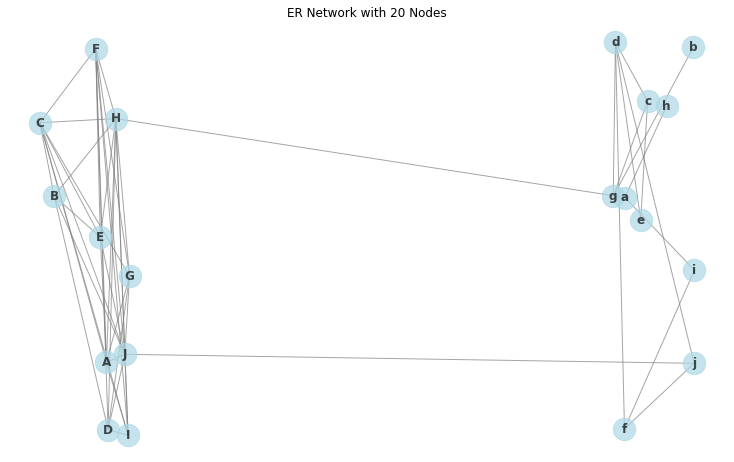

In [54]:
# 绘制网络图
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=12, font_color='black', font_weight='bold', edge_color='gray', width=1.0, alpha=0.7)
plt.title('ER Network with 20 Nodes')
plt.show()


In [6]:
# 创建存储节点信息的字典
node_info1 = {}

# 给每个节点按顺序编号，并存储邻居信息
node_to_index1 = {node: i for i, node in enumerate(upper_nodes + lower_nodes)}

for node in sorted(G.nodes()):
    neighbors_indices = [node_to_index1[neighbor] for neighbor in sorted(G.neighbors(node))]
    node_info1[node] = { 'index': node_to_index1[node], 'neighbors': neighbors_indices }

# 输出节点信息到控制台
for node, info in sorted(node_info1.items()):
    print(f"Node {node}: Index = {info['index']}, Neighbors = {info['neighbors']}")


Node A: Index = 0, Neighbors = [2, 4, 5, 6, 7, 8, 9]
Node B: Index = 1, Neighbors = [2, 3, 4, 7, 9]
Node C: Index = 2, Neighbors = [0, 1, 4, 5, 6, 7, 8, 9]
Node D: Index = 3, Neighbors = [1, 5, 6, 7, 8, 9]
Node E: Index = 4, Neighbors = [0, 1, 2, 5, 7, 9]
Node F: Index = 5, Neighbors = [0, 2, 3, 4, 6, 7, 8, 9]
Node G: Index = 6, Neighbors = [0, 2, 3, 5, 7, 9]
Node H: Index = 7, Neighbors = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10]
Node I: Index = 8, Neighbors = [0, 2, 3, 5, 7, 9]
Node J: Index = 9, Neighbors = [0, 1, 2, 3, 4, 5, 6, 7, 8, 19]
Node a: Index = 10, Neighbors = [7, 17, 18]
Node b: Index = 11, Neighbors = [16]
Node c: Index = 12, Neighbors = [13, 14, 16]
Node d: Index = 13, Neighbors = [12, 14, 15, 16, 19]
Node e: Index = 14, Neighbors = [12, 13]
Node f: Index = 15, Neighbors = [13, 18, 19]
Node g: Index = 16, Neighbors = [11, 12, 13]
Node h: Index = 17, Neighbors = [10]
Node i: Index = 18, Neighbors = [10, 15]
Node j: Index = 19, Neighbors = [9, 13, 15]


In [7]:
# 创建存储节点信息的字典
node_info2 = {}

# 给每个节点按顺序编号，并存储邻居信息
node_to_index2 = {node: i for i, node in enumerate(lower_nodes + upper_nodes)}

for node in sorted(G.nodes()):
    neighbors_indices = [node_to_index2[neighbor] for neighbor in sorted(G.neighbors(node))]
    node_info2[node] = { 'index': node_to_index2[node], 'neighbors': neighbors_indices }

# 输出节点信息到控制台
for node, info in sorted(node_info2.items()):
    print(f"Node {node}: Index = {info['index']}, Neighbors = {info['neighbors']}")


Node A: Index = 10, Neighbors = [12, 14, 15, 16, 17, 18, 19]
Node B: Index = 11, Neighbors = [12, 13, 14, 17, 19]
Node C: Index = 12, Neighbors = [10, 11, 14, 15, 16, 17, 18, 19]
Node D: Index = 13, Neighbors = [11, 15, 16, 17, 18, 19]
Node E: Index = 14, Neighbors = [10, 11, 12, 15, 17, 19]
Node F: Index = 15, Neighbors = [10, 12, 13, 14, 16, 17, 18, 19]
Node G: Index = 16, Neighbors = [10, 12, 13, 15, 17, 19]
Node H: Index = 17, Neighbors = [10, 11, 12, 13, 14, 15, 16, 18, 19, 0]
Node I: Index = 18, Neighbors = [10, 12, 13, 15, 17, 19]
Node J: Index = 19, Neighbors = [10, 11, 12, 13, 14, 15, 16, 17, 18, 9]
Node a: Index = 0, Neighbors = [17, 7, 8]
Node b: Index = 1, Neighbors = [6]
Node c: Index = 2, Neighbors = [3, 4, 6]
Node d: Index = 3, Neighbors = [2, 4, 5, 6, 9]
Node e: Index = 4, Neighbors = [2, 3]
Node f: Index = 5, Neighbors = [3, 8, 9]
Node g: Index = 6, Neighbors = [1, 2, 3]
Node h: Index = 7, Neighbors = [0]
Node i: Index = 8, Neighbors = [0, 5]
Node j: Index = 9, Neighbo

# 或

## 稠密（dense）

In [16]:
# 外部2个节点为00
Col = ['{:010b}00'.format(i) for i in range(2**10)]
dense00 = np.empty((2**10, 2**10))
for i in range(dense00.shape[0]):  
    
    pA = calculate_or_p(i, 0, 2, 4, 5, 6, 7, 8, 9) 
    pB = calculate_or_p(i, 1, 2, 3, 4, 7, 9)
    pC = calculate_or_p(i, 2, 0, 1, 4, 5, 6, 7, 8, 9)
    pD = calculate_or_p(i, 3, 1, 5, 6, 7, 8, 9)
    pE = calculate_or_p(i, 4, 0, 1, 2, 5, 7, 9) 
    pF = calculate_or_p(i, 5, 0, 2, 3, 4, 6, 7, 8, 9)
    pG = calculate_or_p(i, 6, 0, 2, 3, 5, 7, 9)
    pH = calculate_or_p(i, 7, 0, 1, 2, 3, 4, 5, 6, 8, 9, 10)
    pI = calculate_or_p(i, 8, 0, 2, 3, 5, 7, 9)
    pJ = calculate_or_p(i, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 11)

    pABCDEFG = np.kron(pA, np.kron(pB, np.kron(pC, np.kron(pD, np.kron(pE, np.kron(pF, pG))))))
    dense00[i] = np.kron(pABCDEFG, np.kron(pH, np.kron(pI, pJ)))

In [17]:
# 外部2个节点为01
Col = ['{:010b}01'.format(i) for i in range(2**10)]
dense01 = np.empty((2**10, 2**10))
for i in range(dense01.shape[0]):  
    
    pA = calculate_or_p(i, 0, 2, 4, 5, 6, 7, 8, 9) 
    pB = calculate_or_p(i, 1, 2, 3, 4, 7, 9)
    pC = calculate_or_p(i, 2, 0, 1, 4, 5, 6, 7, 8, 9)
    pD = calculate_or_p(i, 3, 1, 5, 6, 7, 8, 9)
    pE = calculate_or_p(i, 4, 0, 1, 2, 5, 7, 9) 
    pF = calculate_or_p(i, 5, 0, 2, 3, 4, 6, 7, 8, 9)
    pG = calculate_or_p(i, 6, 0, 2, 3, 5, 7, 9)
    pH = calculate_or_p(i, 7, 0, 1, 2, 3, 4, 5, 6, 8, 9, 10)
    pI = calculate_or_p(i, 8, 0, 2, 3, 5, 7, 9)
    pJ = calculate_or_p(i, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 11)

    pABCDEFG = np.kron(pA, np.kron(pB, np.kron(pC, np.kron(pD, np.kron(pE, np.kron(pF, pG))))))
    dense01[i] = np.kron(pABCDEFG, np.kron(pH, np.kron(pI, pJ)))

In [18]:
# 外部2个节点为10
Col = ['{:010b}10'.format(i) for i in range(2**10)]
dense10 = np.empty((2**10, 2**10))
for i in range(dense10.shape[0]):  
    
    pA = calculate_or_p(i, 0, 2, 4, 5, 6, 7, 8, 9) 
    pB = calculate_or_p(i, 1, 2, 3, 4, 7, 9)
    pC = calculate_or_p(i, 2, 0, 1, 4, 5, 6, 7, 8, 9)
    pD = calculate_or_p(i, 3, 1, 5, 6, 7, 8, 9)
    pE = calculate_or_p(i, 4, 0, 1, 2, 5, 7, 9) 
    pF = calculate_or_p(i, 5, 0, 2, 3, 4, 6, 7, 8, 9)
    pG = calculate_or_p(i, 6, 0, 2, 3, 5, 7, 9)
    pH = calculate_or_p(i, 7, 0, 1, 2, 3, 4, 5, 6, 8, 9, 10)
    pI = calculate_or_p(i, 8, 0, 2, 3, 5, 7, 9)
    pJ = calculate_or_p(i, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 11)

    pABCDEFG = np.kron(pA, np.kron(pB, np.kron(pC, np.kron(pD, np.kron(pE, np.kron(pF, pG))))))
    dense10[i] = np.kron(pABCDEFG, np.kron(pH, np.kron(pI, pJ)))

In [19]:
# 外部2个节点为11
Col = ['{:010b}11'.format(i) for i in range(2**10)]
dense11 = np.empty((2**10, 2**10))
for i in range(dense11.shape[0]):  
    
    pA = calculate_or_p(i, 0, 2, 4, 5, 6, 7, 8, 9) 
    pB = calculate_or_p(i, 1, 2, 3, 4, 7, 9)
    pC = calculate_or_p(i, 2, 0, 1, 4, 5, 6, 7, 8, 9)
    pD = calculate_or_p(i, 3, 1, 5, 6, 7, 8, 9)
    pE = calculate_or_p(i, 4, 0, 1, 2, 5, 7, 9) 
    pF = calculate_or_p(i, 5, 0, 2, 3, 4, 6, 7, 8, 9)
    pG = calculate_or_p(i, 6, 0, 2, 3, 5, 7, 9)
    pH = calculate_or_p(i, 7, 0, 1, 2, 3, 4, 5, 6, 8, 9, 10)
    pI = calculate_or_p(i, 8, 0, 2, 3, 5, 7, 9)
    pJ = calculate_or_p(i, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 11)

    pABCDEFG = np.kron(pA, np.kron(pB, np.kron(pC, np.kron(pD, np.kron(pE, np.kron(pF, pG))))))
    dense11[i] = np.kron(pABCDEFG, np.kron(pH, np.kron(pI, pJ)))

In [20]:
A00 = tpm_ei(dense00, log_base = 2)
print(A00)  

0.3278255197981464


In [21]:
A01 = tpm_ei(dense01, log_base = 2)
print(A01)  

0.3278255197981464


In [22]:
A10 = tpm_ei(dense10, log_base = 2)
print(A10)  

0.3278255197981464


In [23]:
A11 = tpm_ei(dense11, log_base = 2)
print(A11)    

0.3278255197981464


In [24]:
print((A00 + A01 + A10 + A11) / 4)   

0.3278255197981464


## 稀疏（thin）

In [25]:
# 外部2个节点为00
Col = ['{:010b}00'.format(i) for i in range(2**10)]
thin00 = np.empty((2**10, 2**10))
for i in range(thin00.shape[0]):  
    
    pa = calculate_or_p(i, 0, 7, 8, 10) 
    pb = calculate_or_p(i, 1, 6)
    pc = calculate_or_p(i, 2, 3, 4, 6)
    pd = calculate_or_p(i, 3, 2, 4, 5, 6, 9)
    pe = calculate_or_p(i, 4, 2, 3) 
    pf = calculate_or_p(i, 5, 3, 8, 9)  
    pg = calculate_or_p(i, 6, 1, 2, 3)
    ph = calculate_or_p(i, 7, 0)
    pi = calculate_or_p(i, 8, 0, 5)
    pj = calculate_or_p(i, 9, 3, 5, 11)

    pabcdefg = np.kron(pa, np.kron(pb, np.kron(pc, np.kron(pd, np.kron(pe, np.kron(pf, pg))))))
    thin00[i] = np.kron(pabcdefg, np.kron(ph, np.kron(pi, pj)))

In [26]:
# 外部2个节点为01
Col = ['{:010b}01'.format(i) for i in range(2**10)]
thin01 = np.empty((2**10, 2**10))
for i in range(thin01.shape[0]):  
    
    pa = calculate_or_p(i, 0, 7, 8, 10) 
    pb = calculate_or_p(i, 1, 6)
    pc = calculate_or_p(i, 2, 3, 4, 6)
    pd = calculate_or_p(i, 3, 2, 4, 5, 6, 9)
    pe = calculate_or_p(i, 4, 2, 3) 
    pf = calculate_or_p(i, 5, 3, 8, 9)  
    pg = calculate_or_p(i, 6, 1, 2, 3)
    ph = calculate_or_p(i, 7, 0)
    pi = calculate_or_p(i, 8, 0, 5)
    pj = calculate_or_p(i, 9, 3, 5, 11)

    pabcdefg = np.kron(pa, np.kron(pb, np.kron(pc, np.kron(pd, np.kron(pe, np.kron(pf, pg))))))
    thin01[i] = np.kron(pabcdefg, np.kron(ph, np.kron(pi, pj)))

In [27]:
# 外部2个节点为10
Col = ['{:010b}10'.format(i) for i in range(2**10)]
thin10 = np.empty((2**10, 2**10))
for i in range(thin10.shape[0]):  
    
    pa = calculate_or_p(i, 0, 7, 8, 10) 
    pb = calculate_or_p(i, 1, 6)
    pc = calculate_or_p(i, 2, 3, 4, 6)
    pd = calculate_or_p(i, 3, 2, 4, 5, 6, 9)
    pe = calculate_or_p(i, 4, 2, 3) 
    pf = calculate_or_p(i, 5, 3, 8, 9)  
    pg = calculate_or_p(i, 6, 1, 2, 3)
    ph = calculate_or_p(i, 7, 0)
    pi = calculate_or_p(i, 8, 0, 5)
    pj = calculate_or_p(i, 9, 3, 5, 11)

    pabcdefg = np.kron(pa, np.kron(pb, np.kron(pc, np.kron(pd, np.kron(pe, np.kron(pf, pg))))))
    thin10[i] = np.kron(pabcdefg, np.kron(ph, np.kron(pi, pj)))

In [28]:
# 外部2个节点为11
Col = ['{:010b}11'.format(i) for i in range(2**10)]
thin11 = np.empty((2**10, 2**10))
for i in range(thin11.shape[0]):  
    
    pa = calculate_or_p(i, 0, 7, 8, 10) 
    pb = calculate_or_p(i, 1, 6)
    pc = calculate_or_p(i, 2, 3, 4, 6)
    pd = calculate_or_p(i, 3, 2, 4, 5, 6, 9)
    pe = calculate_or_p(i, 4, 2, 3) 
    pf = calculate_or_p(i, 5, 3, 8, 9)  
    pg = calculate_or_p(i, 6, 1, 2, 3)
    ph = calculate_or_p(i, 7, 0)
    pi = calculate_or_p(i, 8, 0, 5)
    pj = calculate_or_p(i, 9, 3, 5, 11)

    pabcdefg = np.kron(pa, np.kron(pb, np.kron(pc, np.kron(pd, np.kron(pe, np.kron(pf, pg))))))
    thin11[i] = np.kron(pabcdefg, np.kron(ph, np.kron(pi, pj)))

In [29]:
a00 = tpm_ei(thin00, log_base = 2)
print(a00)  

3.6457678931614907


In [30]:
a01 = tpm_ei(thin01, log_base = 2)
print(a01) 

3.3730408827272775


In [31]:
a10 = tpm_ei(thin10, log_base = 2)
print(a10) 

3.483351492289847


In [32]:
a11 = tpm_ei(thin11, log_base = 2)
print(a11)  

3.2021397537484155


In [33]:
print((a00 + a01 + a10 + a11) / 4) 

3.4260750054817577


# 异或

## 稠密（dense）

In [36]:
# 外部2个节点为00
Col = ['{:010b}00'.format(i) for i in range(2**10)]
dense00 = np.empty((2**10, 2**10))
for i in range(dense00.shape[0]):  
    
    pA = calculate_xor_p(i, 0, 2, 4, 5, 6, 7, 8, 9) 
    pB = calculate_xor_p(i, 1, 2, 3, 4, 7, 9)
    pC = calculate_xor_p(i, 2, 0, 1, 4, 5, 6, 7, 8, 9)
    pD = calculate_xor_p(i, 3, 1, 5, 6, 7, 8, 9)
    pE = calculate_xor_p(i, 4, 0, 1, 2, 5, 7, 9) 
    pF = calculate_xor_p(i, 5, 0, 2, 3, 4, 6, 7, 8, 9)
    pG = calculate_xor_p(i, 6, 0, 2, 3, 5, 7, 9)
    pH = calculate_xor_p(i, 7, 0, 1, 2, 3, 4, 5, 6, 8, 9, 10)
    pI = calculate_xor_p(i, 8, 0, 2, 3, 5, 7, 9)
    pJ = calculate_xor_p(i, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 11)

    pABCDEFG = np.kron(pA, np.kron(pB, np.kron(pC, np.kron(pD, np.kron(pE, np.kron(pF, pG))))))
    dense00[i] = np.kron(pABCDEFG, np.kron(pH, np.kron(pI, pJ)))

In [37]:
# 外部2个节点为01
Col = ['{:010b}01'.format(i) for i in range(2**10)]
dense01 = np.empty((2**10, 2**10))
for i in range(dense01.shape[0]):  
    
    pA = calculate_xor_p(i, 0, 2, 4, 5, 6, 7, 8, 9) 
    pB = calculate_xor_p(i, 1, 2, 3, 4, 7, 9)
    pC = calculate_xor_p(i, 2, 0, 1, 4, 5, 6, 7, 8, 9)
    pD = calculate_xor_p(i, 3, 1, 5, 6, 7, 8, 9)
    pE = calculate_xor_p(i, 4, 0, 1, 2, 5, 7, 9) 
    pF = calculate_xor_p(i, 5, 0, 2, 3, 4, 6, 7, 8, 9)
    pG = calculate_xor_p(i, 6, 0, 2, 3, 5, 7, 9)
    pH = calculate_xor_p(i, 7, 0, 1, 2, 3, 4, 5, 6, 8, 9, 10)
    pI = calculate_xor_p(i, 8, 0, 2, 3, 5, 7, 9)
    pJ = calculate_xor_p(i, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 11)

    pABCDEFG = np.kron(pA, np.kron(pB, np.kron(pC, np.kron(pD, np.kron(pE, np.kron(pF, pG))))))
    dense01[i] = np.kron(pABCDEFG, np.kron(pH, np.kron(pI, pJ)))

In [38]:
# 外部2个节点为10
Col = ['{:010b}10'.format(i) for i in range(2**10)]
dense10 = np.empty((2**10, 2**10))
for i in range(dense10.shape[0]):  
    
    pA = calculate_xor_p(i, 0, 2, 4, 5, 6, 7, 8, 9) 
    pB = calculate_xor_p(i, 1, 2, 3, 4, 7, 9)
    pC = calculate_xor_p(i, 2, 0, 1, 4, 5, 6, 7, 8, 9)
    pD = calculate_xor_p(i, 3, 1, 5, 6, 7, 8, 9)
    pE = calculate_xor_p(i, 4, 0, 1, 2, 5, 7, 9) 
    pF = calculate_xor_p(i, 5, 0, 2, 3, 4, 6, 7, 8, 9)
    pG = calculate_xor_p(i, 6, 0, 2, 3, 5, 7, 9)
    pH = calculate_xor_p(i, 7, 0, 1, 2, 3, 4, 5, 6, 8, 9, 10)
    pI = calculate_xor_p(i, 8, 0, 2, 3, 5, 7, 9)
    pJ = calculate_xor_p(i, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 11)

    pABCDEFG = np.kron(pA, np.kron(pB, np.kron(pC, np.kron(pD, np.kron(pE, np.kron(pF, pG))))))
    dense10[i] = np.kron(pABCDEFG, np.kron(pH, np.kron(pI, pJ)))

In [39]:
# 外部2个节点为11
Col = ['{:010b}11'.format(i) for i in range(2**10)]
dense11 = np.empty((2**10, 2**10))
for i in range(dense11.shape[0]):  
    
    pA = calculate_xor_p(i, 0, 2, 4, 5, 6, 7, 8, 9) 
    pB = calculate_xor_p(i, 1, 2, 3, 4, 7, 9)
    pC = calculate_xor_p(i, 2, 0, 1, 4, 5, 6, 7, 8, 9)
    pD = calculate_xor_p(i, 3, 1, 5, 6, 7, 8, 9)
    pE = calculate_xor_p(i, 4, 0, 1, 2, 5, 7, 9) 
    pF = calculate_xor_p(i, 5, 0, 2, 3, 4, 6, 7, 8, 9)
    pG = calculate_xor_p(i, 6, 0, 2, 3, 5, 7, 9)
    pH = calculate_xor_p(i, 7, 0, 1, 2, 3, 4, 5, 6, 8, 9, 10)
    pI = calculate_xor_p(i, 8, 0, 2, 3, 5, 7, 9)
    pJ = calculate_xor_p(i, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 11)

    pABCDEFG = np.kron(pA, np.kron(pB, np.kron(pC, np.kron(pD, np.kron(pE, np.kron(pF, pG))))))
    dense11[i] = np.kron(pABCDEFG, np.kron(pH, np.kron(pI, pJ)))

In [40]:
A00 = tpm_ei(dense00, log_base = 2)
print(A00)  

7.0


In [41]:
A01 = tpm_ei(dense01, log_base = 2)
print(A01) 

7.0


In [42]:
A10 = tpm_ei(dense10, log_base = 2)
print(A10) 

7.0


In [43]:
A11 = tpm_ei(dense11, log_base = 2)
print(A11) 

7.0


In [44]:
print((A00 + A01 + A10 + A11) / 4)  

7.0


## 稀疏（thin）

In [45]:
# 外部2个节点为00
Col = ['{:010b}00'.format(i) for i in range(2**10)]
thin00 = np.empty((2**10, 2**10))
for i in range(thin00.shape[0]):  
    
    pa = calculate_xor_p(i, 0, 7, 8, 10) 
    pb = calculate_xor_p(i, 1, 6)
    pc = calculate_xor_p(i, 2, 3, 4, 6)
    pd = calculate_xor_p(i, 3, 2, 4, 5, 6, 9)
    pe = calculate_xor_p(i, 4, 2, 3) 
    pf = calculate_xor_p(i, 5, 3, 8, 9)  
    pg = calculate_xor_p(i, 6, 1, 2, 3)
    ph = calculate_xor_p(i, 7, 0)
    pi = calculate_xor_p(i, 8, 0, 5)
    pj = calculate_xor_p(i, 9, 3, 5, 11)

    pabcdefg = np.kron(pa, np.kron(pb, np.kron(pc, np.kron(pd, np.kron(pe, np.kron(pf, pg))))))
    thin00[i] = np.kron(pabcdefg, np.kron(ph, np.kron(pi, pj)))

In [46]:
# 外部2个节点为01
Col = ['{:010b}01'.format(i) for i in range(2**10)]
thin01 = np.empty((2**10, 2**10))
for i in range(thin01.shape[0]):  
    
    pa = calculate_xor_p(i, 0, 7, 8, 10) 
    pb = calculate_xor_p(i, 1, 6)
    pc = calculate_xor_p(i, 2, 3, 4, 6)
    pd = calculate_xor_p(i, 3, 2, 4, 5, 6, 9)
    pe = calculate_xor_p(i, 4, 2, 3) 
    pf = calculate_xor_p(i, 5, 3, 8, 9)  
    pg = calculate_xor_p(i, 6, 1, 2, 3)
    ph = calculate_xor_p(i, 7, 0)
    pi = calculate_xor_p(i, 8, 0, 5)
    pj = calculate_xor_p(i, 9, 3, 5, 11)

    pabcdefg = np.kron(pa, np.kron(pb, np.kron(pc, np.kron(pd, np.kron(pe, np.kron(pf, pg))))))
    thin01[i] = np.kron(pabcdefg, np.kron(ph, np.kron(pi, pj)))

In [47]:
# 外部2个节点为10
Col = ['{:010b}10'.format(i) for i in range(2**10)]
thin10 = np.empty((2**10, 2**10))
for i in range(thin10.shape[0]):  
    
    pa = calculate_xor_p(i, 0, 7, 8, 10) 
    pb = calculate_xor_p(i, 1, 6)
    pc = calculate_xor_p(i, 2, 3, 4, 6)
    pd = calculate_xor_p(i, 3, 2, 4, 5, 6, 9)
    pe = calculate_xor_p(i, 4, 2, 3) 
    pf = calculate_xor_p(i, 5, 3, 8, 9)  
    pg = calculate_xor_p(i, 6, 1, 2, 3)
    ph = calculate_xor_p(i, 7, 0)
    pi = calculate_xor_p(i, 8, 0, 5)
    pj = calculate_xor_p(i, 9, 3, 5, 11)

    pabcdefg = np.kron(pa, np.kron(pb, np.kron(pc, np.kron(pd, np.kron(pe, np.kron(pf, pg))))))
    thin10[i] = np.kron(pabcdefg, np.kron(ph, np.kron(pi, pj)))

In [48]:
# 外部2个节点为11
Col = ['{:010b}11'.format(i) for i in range(2**10)]
thin11 = np.empty((2**10, 2**10))
for i in range(thin11.shape[0]):  
    
    pa = calculate_xor_p(i, 0, 7, 8, 10) 
    pb = calculate_xor_p(i, 1, 6)
    pc = calculate_xor_p(i, 2, 3, 4, 6)
    pd = calculate_xor_p(i, 3, 2, 4, 5, 6, 9)
    pe = calculate_xor_p(i, 4, 2, 3) 
    pf = calculate_xor_p(i, 5, 3, 8, 9)  
    pg = calculate_xor_p(i, 6, 1, 2, 3)
    ph = calculate_xor_p(i, 7, 0)
    pi = calculate_xor_p(i, 8, 0, 5)
    pj = calculate_xor_p(i, 9, 3, 5, 11)

    pabcdefg = np.kron(pa, np.kron(pb, np.kron(pc, np.kron(pd, np.kron(pe, np.kron(pf, pg))))))
    thin11[i] = np.kron(pabcdefg, np.kron(ph, np.kron(pi, pj)))

In [49]:
a00 = tpm_ei(thin00, log_base = 2)
print(a00)  

9.0


In [50]:
a01 = tpm_ei(thin01, log_base = 2)
print(a01) 

9.0


In [51]:
a10 = tpm_ei(thin10, log_base = 2)
print(a10) 

9.0


In [52]:
a11 = tpm_ei(thin11, log_base = 2)
print(a11)  

9.0


In [53]:
print((a00 + a01 + a10 + a11) / 4) 

9.0
